In [19]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from skimage.util.shape import view_as_windows, view_as_blocks

- torch.nn.functional : Convolution, Pooling, Non-linear activation, linear, Dropout, embedding, Loss 등과 관련된 function들이 있음.
- skimage.util.shape.view_as_windows : Block view of the input n-dimensional array (using re-striding).
- skimage.util.shape.view_as_blocks : Rolling window view of the input n-dimensional array.

In [2]:
os.getcwd()

'E:\\BH2\\study\\Kaggle\\Digit Recognizer'

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_submission = pd.read_csv('./data/sample_submission.csv')

In [11]:
print(df_train.shape)
print(df_test.shape)

(42000, 785)
(28000, 784)


In [14]:
side = 28

class ImageDataset(Dataset):
    def __init__(self, df, side):
        self.df = df_train
        self.side = side
    def __len__(self):
        return(len(self.df))
    def __getitem__(self, idx):
        if type(idx) == int:
            idx = [idx]
        sample_df = self.df.loc[idx]
        return {'X': sample_df[sample_df.columns[1:]].values.reshape(1,side,side)/255.0, 'y':sample_df['label'].values}

In [15]:
train_set = ImageDataset(df_train, side)

train_set을 보고 싶은데 어떻게 보지?

In [49]:
seed = 234
torch.manual_seed(seed)

In [50]:
# Define Loss as a torch.nn.Module subclass with the actual loss evaluation in the forward method
# Use torch functions to have the gradients handled by autograd
  
class categorical_cross_entropy(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        
    def forward(self,y_hat,y):  
        for i in range(y_hat.shape[0]):
            y_b = torch.zeros(y_hat.shape[1])
            y_b[y[i]] = 1
            left = -(y_b * torch.log(eps+torch.abs(y_hat[i])))
            right = - (1-y_b) * torch.log(eps+torch.abs(1-y_hat[i]))
            cce =  (left+right).sum()
            if cce != cce or cce == np.inf:
                print(cce)
                print('y_b', y_b.shape,y_b)
                print('y_hat',y_hat[i].shape,y_hat[i])
                print('left',left)
                print('right',right)
                raise Exception('Loss become NaN or infinite')
            if i == 0:
                loss = cce
            else:
                loss += cce
        return loss/(y_hat.shape[0])

In [51]:
# Define complex function (e.g. complex activation) as a torch.autograd.Function subclass
# Define forward and backward methods as static methods
# forward() takes the input (e.g. from previous layer activations) 
# saves necessary context objects, applies the function and returns the output
# backward() takes as input the gradient from the more inner function of the gradient chain (e.g. from next layer activations)
# uses necessary context objects, applies the gradient of the function and returns the next step of the gradient chain
# if any the function will also return the gradient with respect to the layer's parameters (e.g. fully connected layers, convolutional layers)

# LeakyReLU(x) = x if x > 0, 0.01x elsewhere
# d LeakyRelu(x)/dx = 1 if x > 0, 0.01 elsewhere
class LeakyReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = input.clone()
        output[output<0] = output[output<0]*0.01
        if (output != output).any() or (output == np.inf).any():
            print('Leaky_Relu fw', (input != input).any())
            print('Leaky_Relu fw', (output != output).any())
            #raise Exception('Problema in LeakyRelu Forward')
        return output
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = grad_input[input < 0]*0.01
        if  (grad_input != grad_input).any() or (grad_input == np.inf).any():
            print('Leaky_Relu bw', grad_output.sum(), grad_output.shape)
            print('Leaky_Relu bw', grad_input.sum())
            #raise Exception('Problema in LeakyRelu Backward')
        return grad_input    

    
# Define the complex function as a normal function using apply

leaky_relu = LeakyReLU.apply


class Sigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = 1/(1+torch.exp(-input))
        if (output != output).any() or (output == np.inf).any():
            print('sigmoid fw', (input != input).any())
            print('sigmoid fw', (output != output).any())
        return output
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = 1/(1+torch.exp(-input))
        grad_input = grad_output*grad_input * (1-grad_input)
        if  (grad_input != grad_input).any() or (grad_input == np.inf).any():
            print('sigmoid bw', grad_output.sum(), grad_output.shape)
            print('sigmoid bw', grad_input.sum())
        return grad_input
    
sigmoid = Sigmoid.apply

    
# Define layers as a torch.nn.Module subclass, defines values to be optimised as Parameters
# Use torch functions to have the gradients handled by autograd

class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(out_features, in_features))
        self.b = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        # smart initialisation as per smart researchers' directive
        nn.init.kaiming_uniform_(self.W, a=np.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.b, -bound, bound)
        
    def forward(self, input):
        output = input.mm(self.W.t())+self.b
        if (output != output).any() or (output == np.inf).any():
            print(output == np.inf)
            print('Linear input', input.sum())
            print('Linear output', output.sum())
            print('Linear weights', self.W.sum())
            print('Linear bias', self.b.sum())
            #raise Exception('Problema in Linear Forward')
        return output
        
        
# Drop activations randomly during training

class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        if self.training:
            output = torch.where(torch.rand_like(input) < self.p, torch.zeros_like(input), input)
        else:
            output = input
            
        if (output != output).any() or (output == np.inf).any():
            print('Dropout input', input.sum())
            print('Dropout output', output.sum())
            #raise Exception('Problema in Dropout Forward')
        return output
    
# Drop entire channels randomly during training
    
class Dropout2D(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        if self.training:
            dropping_channels = torch.where(torch.rand(input.shape[1]) < self.p, torch.zeros(input.shape[1]), torch.ones(input.shape[1])) == 1#torch.randn(input.shape[1]) > 0
            output = input.clone()
            output[:,dropping_channels,:,:]=0
        else:
            output = input
            
        if (output != output).any() or (output == np.inf).any():
            print('Dropout2d input', input.sum())
            print('Dropout2d output', output.sum())
            #raise Exception('Problema in Dropout2d Forward')
        return output
    

    
# Define complex layers with custom backward as torch.nn.Module with helper autograd.Function
# This is NOT how you do convolution nowadays since it's very slow, look at Winograd fast convolutions
    
## Use little helper functions too
### terrible performance, unused, naive implementation of convolution with loops
def naive_convolution(A,B,n_out,k_size): 
    C = np.zeros((n_out, n_out))
    for j in range(n_out):
        for k in range(n_out):
            C[j,k] = (A[:,j:j+k_size,k:k+k_size]*B).sum() 
    return C

### bad performance, unused, naive implementation of windowing, use matrix multiplication instead of Hadamard product
def naive_no_hadamard_conv(A,B_flattened,n_out,k_size):  
    A_ = np.zeros((A.shape[0]*k_size*k_size, n_out*n_out))
    i = 0
    for j in range(n_out):
        for k in range(n_out):
            A_[:,i] = A[:,j:j+k_size,k:k+k_size].flatten()
            i += 1
    return B_flattened.dot(A_).reshape(n_out,n_out)

### passable performance, other optimisations are possible, changes memory representation of data to window efficiently, then uses matrix multiplication
### A has 3 dimensions, B has 4, output has 3
def strided_no_hadamard_conv(A,B,B_flattened,n_out,k_size): 
    return np.dot(B_flattened,view_as_windows(A,B.shape[1:]).reshape(n_out*n_out, B_flattened.shape[1]).T).reshape(B.shape[0], n_out, n_out)

def convolute(A, B, B_flattened):
    # Prepare A for full convolution (which is a modified convolution), used in gradient computation
    if A.shape[1] < B.shape[2]:
        A_ = np.zeros((A.shape[0],(B.shape[2]-1)*2+A.shape[1],(B.shape[2]-1)*2+A.shape[1]))
        A_[:,B.shape[2]-1:B.shape[2]-1+A.shape[1],B.shape[2]-1:B.shape[2]-1+A.shape[1]] = A
        A = A_
    
    # A is the input, B is the kernel, B_flattened is the kernel manipulated and already stored for better performance
    k_size = B.shape[2]
    
    # Compute the size of the output image, no stride implemented, nor padding
    n_out = A.shape[1] - k_size + 1
    
    #C = naive_convolution(A,B,n_out,k_size) # B was a single filter
    #C = naive_no_hadamard_conv(A,B_flattened,n_out,k_size) # B was a single filter
    C = strided_no_hadamard_conv(A,B,B_flattened,n_out,k_size) # B is a group of filters
    return C
    
class Convolution2D(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input, kernel, stride):
        ctx.save_for_backward(input, kernel, stride)
        
        # Only squared kernel and squared input implemented, strides not working
        out_channels = kernel.shape[0]
        batch_size = input.shape[0]
        in_size = input.shape[2]
        n_out = int((in_size - kernel.shape[2])/stride)+1
        output = torch.zeros((batch_size, out_channels, n_out, n_out))
        input = input.detach().cpu().numpy()
        kernel = kernel.detach().cpu().numpy()
        kernel_flattened =kernel.reshape(out_channels,-1)
        
        # for each 3d Tensor element in batch (Channels X Size X Size)
        # convolute the element with the kernel (Number of filters X Channels X Kernel Size X Kernel Size)
        # to have one 3d Tensor (Number of filters X Output Size x Output Size)
        # complete output is a 4d Tensor (Batch Size X Number of filters X Output Size x Output Size)
        for batch in range(batch_size):
            output[batch] = torch.Tensor(convolute(input[batch], kernel, kernel_flattened))
            
        if (output != output).any() or (output == np.inf).any():
            print('Conv2d input fw', input.sum())
            print('Conv2d output fw', output.sum())
            print('Conv2d kernel fw', kernel.sum())
            #raise Exception('Problema in Conv2d Forward')
            
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, kernel, stride = ctx.saved_tensors
        
        # Compute gradients with respect to the input and gradients with respect to the weights
        batch_size = input.shape[0]
        out_size = input.shape[2]
        grad_kernel = np.zeros((kernel.shape[1], kernel.shape[0],kernel.shape[2],kernel.shape[3]))
        grad_input = np.zeros((kernel.shape[1], batch_size, out_size, out_size))
        
        # The mathematical subtlety is lost to me, go check out gradients of convolutional layers on your preferred search engine
        # Just know that convolution can be used to compute both with some neat tricks, among which flipping kernels, swapping axes, doing a full convolution.
        
        input = np.swapaxes(input.detach().numpy(), 0,1)
        flipped_kernel = np.swapaxes(kernel.flip([2,3]).detach().numpy(), 0,1)
        grad_output = grad_output.detach().numpy()
        grad_output_swap = np.swapaxes(grad_output,0,1)
        grad_output_flattened = grad_output.reshape(grad_output.shape[0],-1)
        grad_output_swap_flattened = grad_output_swap.reshape(grad_output_swap.shape[0],-1)

        for channel_i in range(kernel.shape[1]):
            grad_kernel[channel_i] = convolute(input[channel_i], grad_output_swap, grad_output_swap_flattened)
            grad_input[channel_i] = convolute(flipped_kernel[channel_i], grad_output, grad_output_flattened)
            
        grad_input = torch.Tensor(np.swapaxes(grad_input,0,1)).flip([-2,-1])
        grad_kernel = torch.Tensor(np.swapaxes(grad_kernel,0,1))
            
        if (grad_input != grad_input).any() or (grad_kernel != grad_kernel).any() or (grad_input == np.inf).any() or (grad_kernel == np.inf).any():
            print('Conv2d input bw', grad_output.sum())
            print('Conv2d output bw', grad_input.sum())
            print('Conv2d kernel bw', grad_kernel.sum())
            #raise Exception('Problema in Conv2d Backward')
            
        return grad_input, grad_kernel, None

convolution2d = Convolution2D.apply
    
class Conv2DSquared(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.stride = torch.ones(1) # don't want to think about stride in backpropagation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.kernel, a=np.sqrt(5))

    def forward(self, input):
        # input [batch_size x input_channels x rows x columns]
        # output [batch_size x output_channels x new rows x new columns]
        # kernel [output_channels x input_channels x kernel_size x kernel_size]
        return convolution2d(input, self.kernel, self.stride)

    
class MaxPool2Df(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, pool_size):
        pool_t = pool_size * torch.ones(1)
        input_array = input.detach().numpy()
        
        # Compute the mask to be passed to the backward 
        # the mask is  a tensor of the same shape as the input, with 1 where max value of a pool window is found, 0 elsewhere
        mask = np.zeros_like(input_array)
        
        # Boxed tensors are fast to access views of the pool windows, edits on them affect the original tensor
        boxed_input = view_as_blocks(input_array, (input_array.shape[0],input_array.shape[1],pool_size,pool_size))
        boxed_input_mat = boxed_input.reshape(-1,pool_size*pool_size)
        
        # Create mask from the boxed input
        boxed_mask_mat = np.zeros(boxed_input_mat.shape)
        boxed_mask_mat[np.arange(len(boxed_input_mat)), boxed_input_mat.argmax(axis=1)] = 1
        boxed_mask = boxed_mask_mat.reshape(-1,pool_size,pool_size).reshape(boxed_input.shape)
        
        # Use boxed view to copy the mask values efficiently
        mask_blocks = view_as_blocks(mask, (input_array.shape[0],input_array.shape[1],pool_size,pool_size)) 
        mask_blocks[0] = boxed_mask[0]
        
        output = np.zeros((input_array.shape[0],input_array.shape[1],int(input_array.shape[2]/pool_size),int(input_array.shape[2]/pool_size)))
        output_blocks = view_as_blocks(output, (input_array.shape[0],input_array.shape[1], 1, 1))
        
        # Find maximum value in each pool window, and use boxed view to copy it into the output
        output_blocks[0] = boxed_input_mat.max(axis=1).reshape(output_blocks.shape)[0]
        
        ctx.save_for_backward(input, torch.Tensor(mask), pool_t)
        
        output = torch.Tensor(output)
        
        if (output != output).any() or (output == np.inf).any():
            print('MaxPool input fw', input.sum())
            print('MaxPool output fw', output.sum())
            #raise Exception('Problema in MaxPool Forward')
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, mask, pool_t = ctx.saved_tensors
        input_array = input.detach().numpy()
        grad_output_array = grad_output.detach().numpy()
        pool_size = int(pool_t)
        
        mask_array = mask.detach().numpy()
        grad_input = np.zeros_like(mask_array)
        
        # Compute gradient with respect to the input by just passing the gradients from the outer layer to 
        # the neurons that passed the max values in the forward section
        
        grad_input_blocks = view_as_blocks(grad_input, (mask_array.shape[0],mask_array.shape[1],pool_size,pool_size))
        mask_blocks = view_as_blocks(mask_array, (mask_array.shape[0],mask_array.shape[1],pool_size,pool_size)) 
        grad_output_blocks = view_as_blocks(grad_output_array, (mask_array.shape[0],mask_array.shape[1], 1, 1))
        
        # Hadamard product between tensor and vector
        boxed_grad_input = grad_output_blocks*mask_blocks
        grad_input_blocks[0] = boxed_grad_input[0]
        
        grad_input = torch.Tensor(grad_input)

        if (grad_input != grad_input).any() or (grad_input == np.inf).any():
            print('MaxPool input bw', grad_output.sum())
            print('MaxPool output bw', grad_input.sum())
            #raise Exception('Problema in MaxPool Backward')
        
        return grad_input, None

max_pool2d = MaxPool2Df.apply

class MaxPool2D(nn.Module):
    def __init__(self, pool_size):
        super().__init__()
        self.pool_size = pool_size
        
    def forward(self, input):
        return max_pool2d(input, self.pool_size)
    
    
# Define solver/optimiser as a torch.optim.Optimizer subclass

class Adamax(optim.Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        
        # all required hyperparameters
        # lr (learning rate) is the "step" size of the descent towards the minimum
        # betas are the two constants balancing the novelty of the current gradients with the steadiness of the moments
        ## high values favour the moment, low values favour the gradients
        # eps is the correction constant to avoid divisions by zero
        
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(Adamax, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adamax, self).__setstate__(state)            

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_max'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)

                exp_avg, exp_avg_max = state['exp_avg'], state['exp_avg_max']

                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and infinite moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_max = torch.max(exp_avg_max*beta2, np.abs(grad))
                state['exp_avg_max'] = exp_avg_max

                step_size = group['lr']
                p.data.add_((-step_size*exp_avg)/(exp_avg_max+eps))

        return loss

In [52]:
# Define the model

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = Conv2DSquared(1, 16, 3)#nn.Conv2d(1, 32, 3, 1)#
        self.conv2 = Conv2DSquared(16, 64, 3)#nn.Conv2d(32, 64, 3, 1)#
        self.dropout1 = Dropout2D(0.25)
        self.dropout2 = Dropout(0.5)
        self.fc1 = Linear(7744, 128) # 7744
        self.fc2 = Linear(128, 10)
        self.mp1 = MaxPool2D(2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.mp1(x)
        x = leaky_relu(x)
        x = self.conv2(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = leaky_relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = sigmoid(x)
        return x

In [53]:
# Hyperparameters

batch_size = 64
base_lr = 1e-6
max_lr = 6*1e-3
epochs = 10
gamma = 0.5
step_schedule = 3
eps=1e-8

In [54]:
%%time
train = DataLoader(train_set, shuffle = False, batch_size = batch_size)

model = Model().float()

# Enveloped sawtooth
def current_lr(epoch):
    return base_lr + (epochs-(epoch%step_schedule))/epochs*(((gamma**(epoch/epochs)) * max_lr) - base_lr)

lr = current_lr(0)

optimiser = Adamax(model.parameters(), lr=lr, eps=eps)

# Define learning rate scheduler by using torch.optim.lr_scheduler.LambdaLR with a custom function
# Function takes current epoch and return the factor by which the original learning rate is multiplied
lr_lambda = lambda epoch: current_lr(epoch)/current_lr(0) if epoch > 0 else 1

scheduler = optim.lr_scheduler.LambdaLR(optimiser, lr_lambda)

criterion = categorical_cross_entropy()
train_history = []
val_history = []

n = len(train_set)
n_batches = len(train)
log_interval = 100
early_stopping = False

# Epoch looping
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    correct = 0
    total = 0

    # Dataset looping, should have divided train and test in two functions and used a different way to divide training and validation set
    # But this wasn't my focus on the cookbook so I chose laziness
    for i, batch in enumerate(train):
        batch_size = batch['y'].shape[0]
        X = batch['X'].float()
        y = batch['y'].reshape(batch_size).long()
        if i < int(n_batches*0.8):
            model.train()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            train_loss += loss.item()
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if i % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i*batch_size, int(len(train)*batch_size*0.8),100. * i / int(len(train)*0.8), loss.item()))
        if i == int(n_batches*0.8):
            train_history.append(train_loss/(int(n_batches*0.8)))
            scheduler.step()
            model.eval()
        if i >= int(n_batches*0.8):
             with torch.no_grad():
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss += loss.item()
                pred = torch.max(y_hat, axis=1)[1]
                correct += pred.eq(y.view_as(pred)).sum().item()
                total += y.shape[0]
    avg_val_loss = val_loss/int(n_batches*0.2)
    print('\nVal Epoch: {}\n Average validation loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch, val_loss/int(n_batches*0.2), correct, total,100. * correct / total))
    val_history.append(avg_val_loss)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


Train Epoch: 0 [0/33638 (0%)]	Loss: 6.940490
Train Epoch: 0 [6400/33638 (19%)]	Loss: 1.503161
Train Epoch: 0 [12800/33638 (38%)]	Loss: 1.063951
Train Epoch: 0 [19200/33638 (57%)]	Loss: 0.596476
Train Epoch: 0 [25600/33638 (76%)]	Loss: 0.690907
Train Epoch: 0 [32000/33638 (95%)]	Loss: 0.977625

Val Epoch: 0
 Average validation loss: 1.4459, Accuracy: 7815/8400 (93%)

Train Epoch: 1 [0/33638 (0%)]	Loss: 0.719366
Train Epoch: 1 [6400/33638 (19%)]	Loss: 0.701353
Train Epoch: 1 [12800/33638 (38%)]	Loss: 1.522654
Train Epoch: 1 [19200/33638 (57%)]	Loss: 0.401919
Train Epoch: 1 [25600/33638 (76%)]	Loss: 0.594361
Train Epoch: 1 [32000/33638 (95%)]	Loss: 0.590494

Val Epoch: 1
 Average validation loss: 0.9629, Accuracy: 8008/8400 (95%)

Train Epoch: 2 [0/33638 (0%)]	Loss: 0.414975
Train Epoch: 2 [6400/33638 (19%)]	Loss: 0.462039
Train Epoch: 2 [12800/33638 (38%)]	Loss: 0.603231
Train Epoch: 2 [19200/33638 (57%)]	Loss: 0.284589
Train Epoch: 2 [25600/33638 (76%)]	Loss: 0.416473
Train Epoch: 2 [32

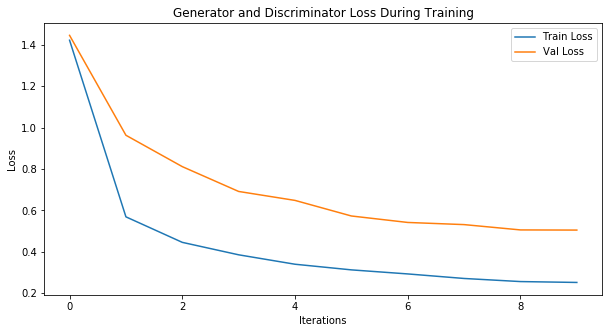

In [55]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(train_history,label="Train Loss")
plt.plot(val_history,label="Val Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [56]:
X_test = torch.Tensor(df_test.values.reshape(-1,1,side,side)/255.0)
pred = model(X_test)
df_submission['Label'] = pred.argmax(axis=1)
df_submission.to_csv('submission.csv', index=False)

In [ ]:
import seaborn as sns
plt.subplots(figsize=(10,9))
ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

Reference :
- https://www.kaggle.com/fleanend/homegrown-nn-cookbook-pytorch
- https://www.kaggle.com/abhinand05/mnist-introduction-to-computervision-with-pytorch